## Автоэнкодеры

Автоэнкодеры - unsupervised модели, которые находят применение как базовые строительные блоки в огромном кол-ве сложных моделей. Он состоит из двух нейронных сетей, называемых _энкодером_ и _декодером_, которые работают в тандеме. Задача энкодера - сжать исходный объект до вектора малой размерности, называемого _латентным кодом_. Задача декодера - восстановить из этого латентного кода исходный объект. 

Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$ Loss = \sum MSE(x_i, dec(enc(x_i)) $$

### Автоэнкодер для MNIST

Давайте реализуем и поиграемся с простым автоэнкодером, который берет изображения из датасета **MNIST** и кодирует их в латентный код длины **k**. В этом задании надо реализовать:

* Encoder
    * Четырехслойная полносвязная сеть с каналами (784-128-64-32-k)
* Decoder
    * Симметричная полносвязная сеть с каналами (k-32-64-128-784)
* Loss функцию для обучения
    * L2 между входом и выходом автоэнкодера

In [2]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder, self).__init__()
        self.lat_size = lat_size
        
        self.enc_net = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, self.lat_size))
        
    def forward(self, x):
        assert x.shape[2] == x.shape[3] == 28
        
        z = self.enc_net(x)
        
        assert z.shape[0] == x.shape[0]
        assert z.shape[1] == self.lat_size
        
        return z
    
class MNISTDecoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid())
        
    def forward(self, z):
        assert z.shape[1] == self.lat_size
        
        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        assert x_rec.shape[0] == z.shape[0]
        
        return x_rec

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, lat_size, 
                 encoder_class=MNISTEncoder, 
                 decoder_class=MNISTDecoder,
                 criterion_class=nn.MSELoss):
        super(AutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def compute_loss(self, x, return_rec=False):
        z = self.encode(x)
        rec_x = self.decode(z)
        
        loss = self.criterion(x, rec_x)
        
        if return_rec:
            return loss, rec_x, z
        else:
            return loss

Теперь давайте обучим автоэнкодер

In [5]:
def train_model(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    lat_codes = []
    labels = []

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        lat_codes_i = torch.empty((0, model.lat_size)).to(device)
        labels_i = torch.empty((0)).to(device)

        for iter_i, batch in enumerate(tr_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x, cur_lat_codes= model.compute_loss(x, return_rec=True)
            lat_codes_i = torch.cat((lat_codes_i, cur_lat_codes), dim=0)
            labels_i = torch.cat((labels_i, y), dim=0)

            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
        lat_codes_i = lat_codes_i[:1000].detach().cpu().numpy()
        labels_i = labels_i[:1000].detach().cpu().numpy()
        lat_codes.append(lat_codes_i)
        labels.append(labels_i)
    model.eval()
    return lat_codes, labels

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=1)

0it [00:00, ?it/s]

KeyboardInterrupt: 

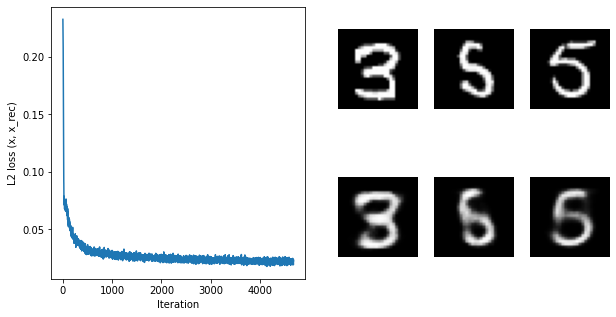

In [ ]:
# обучим модель с латентным кодом длины 8
model = AutoEncoder(8)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

lat_codes, labels = train_model(model, train_dataloader, optimizer)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

### Структура и интерпретация латентного пространства.

Главная ценность автоэнкодера как модели - его латентный код. Он крайне насыщенный, т.к. он должен сохранять как можно больше важной информации об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном пространстве. 

#### Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответсвующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера. 

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [ ]:
for x, _ in train_dataloader:
    break
    
x1 = x[0].to(device)
x2 = x[1].to(device)

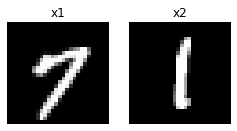

In [ ]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('x1')
plt.imshow(x1[0].cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('x2')
plt.imshow(x2[0].cpu().detach().numpy(), cmap='gray')

In [ ]:
# получите латентные коды объектов
z_1 = model.encode(x1[None, :, :, :])
z_2 = model.encode(x2[None, :, :, :])
assert z_1.shape == z_2.shape == torch.Size([1, 8])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)
assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = model.decode(z_linspace)
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

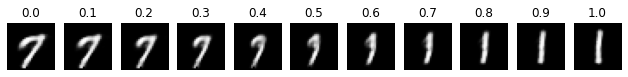

In [ ]:
#нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.title(f'{d:.2}')
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap='gray')


На интерполяция видно, как один объект плавно превращается в другой. Стоит заметить, что почти все промежуточные объекты тоже выглядят довольно правдопободно. Иногда такие интерполяции используют для того, чтобы расширить какой-то маленький датасет.

#### Структура латентного пространства

Теперь давайте обучим автоэнкодер с **2** латентными кодами, соберем эти латентные коды и нарисуем 2d plot, где латентные коды подсвечены цветами классов исходных объектов.

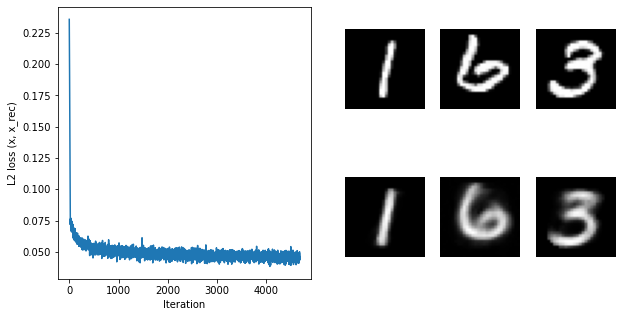

In [ ]:
# обучим автоэнкодер с 2 латентными кодами

model_2d = AutoEncoder(2)
model_2d.to(device)

optimizer = optim.Adam(model_2d.parameters(), lr=1e-3)

lat_codes, labels = train_model(model_2d, train_dataloader, optimizer)

TypeError: ignored

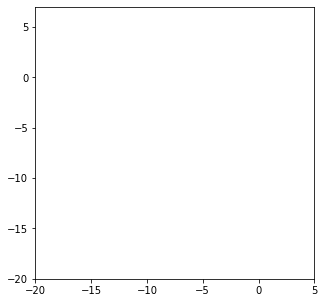

In [ ]:
for i in range(5):
    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    for cl in range(10):
        plt.xlim((-20, 5))
        plt.ylim((-20, 7))
        lat_codes_class = lat_codes[i][labels[i] == cl]
        plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    plt.legend()
    plt.show()

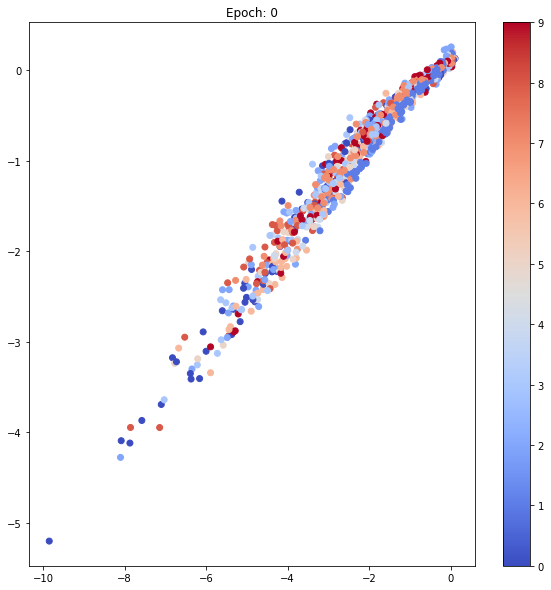

In [ ]:
def make_2d_scatter_gif(lat_codes, labels, fig):
    im = plt.scatter(lat_codes[i][:, 0], lat_codes[i][:, 1], c=labels[i], cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(0))

    def update(i):
        fig.clear()
        im = plt.scatter(lat_codes[i][:, 0], lat_codes[i][:, 1], c=labels[i], cmap=cm.coolwarm)
        im.axes.set_title("Epoch: ", i)
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(lat_codes)), interval=150)
    
make_2d_scatter_gif(lat_codes, labels, plt.figure(figsize=(10,10)))

In [ ]:
def get_latent_codes_and_labels(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_codes = model.encode(x)
    
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels
    
# соберем для 1000 случайных объектов их латентные коды и классы
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_2d, 1000)

assert lat_codes.shape == (1000, 2)
assert labels.shape == (1000, )

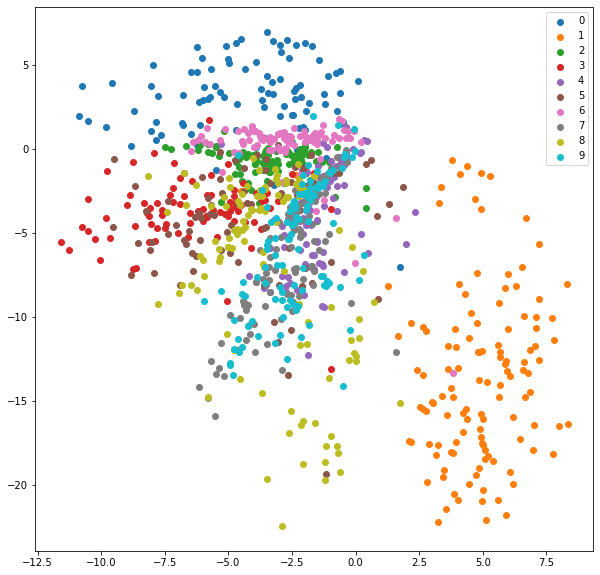

In [ ]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
plt.legend()
plt.show()

Объекты одного и то же класса находятся в латентном пространстве близко друг к другу! При этом визуально похожие классы (1-4 или 4-9) тоже находятся близко друг к другу.

### 3.3 Структура латентного пространства (продолжение)

А теперь давайте обучим автоэнкодер с **32** латентными кодами, а потом сожмем до размемрности **2** с помощью **t-sne**.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
model_big = AutoEncoder(32)
model_big.to(device)
optimizer = optim.Adam(model_big.parameters(), lr=1e-3)

train_model(model_big, train_dataloader, optimizer)

In [ ]:
tsne = TSNE(n_components=2)

In [ ]:
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_big, 1000)

In [ ]:
new_codes = tsne.fit_transform(lat_codes)

In [ ]:
assert new_codes.shape == (1000, 2)
assert labels.shape == (1000,)

In [ ]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = new_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    
plt.legend()
plt.show()

## 4. Denoising

Кроме того, автоэнкодеры часто используют для очистки исходных данных от шума. Латентный код сохраняет только главную информацию об объекте, отбрасывая шумовые компоненты. 

Давайте реализуем функцию, которая обращает 10% пикселей исходного изображения и обучим на такой выборке автоэнкодер.

In [ ]:
class FlipRandomBits(object):
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio
        
    def __call__(self, x):
        mask = (torch.rand_like(x) < self.flip_ratio)
        x[mask] = 1 - x[mask]
        
        return x

transform = transforms.Compose([transforms.ToTensor(), 
                                FlipRandomBits()])

trainset_with_noise = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
train_dataloader_with_noise = torch.utils.data.DataLoader(trainset_with_noise, batch_size=64,
                                          shuffle=True, num_workers=0)


In [ ]:
for x, y in train_dataloader_with_noise:
    break

plt.figure(figsize=(11, 1))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')

In [ ]:
# обучим автоэнкодер на зашумленных данных

model_for_noise = AutoEncoder(64)
model_for_noise.to(device)
optimizer = optim.Adam(model_for_noise.parameters(), lr=1e-3)

train_model(model_for_noise, train_dataloader_with_noise, optimizer)

In [ ]:
_, rec_x = model.compute_loss(x.to(device), return_rec=True)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)
i = 0

for ax, noised, denoised in zip(axs, x[:10], rec_x[:10]):
    ax[0].imshow(noised[0].cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(denoised[0].cpu().detach().numpy(), cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    if i == 0:
        ax[0].set_title(f'Noised')
        ax[1].set_title(f'Denoised')
        i += 1

In [ ]:
for x, y in test_dataloader:
    break
    
_, rec_x = model.compute_loss(x.to(device), return_rec=True)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)
i = 0

for ax, noised, denoised in zip(axs, x[:10], rec_x[:10]):
    ax[0].imshow(noised[0].cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(denoised[0].cpu().detach().numpy(), cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    if i == 0:
        ax[0].set_title(f'Test')
        ax[1].set_title(f'Reconstructed')
        i += 1

## 5. Variational AE

В отличии от обычного автоэнкодера, мы теперь с помощью энкодера предсказываем не конкретную точку в латентном представлении, а распределение. Более того, мы хотим, чтобы наше латентное представление было распределено по нормальному закону. Для этого мы будем использовать метрику `KL дивергенции`. Как только у вас появляются два разных распределения, вы можете посчитать "расстояние" между ними с помощью KL, чем KL меньше, тем два распределения "ближе". Если вероятность семпла x в P большая, а в Q - маленькая, то KL растет. Если иначе, то тоже растет, но не так сильно. 

KL = 0 тогда и только тогда когда P = Q везде. 

Еще раз, как можно видеть по формуле, несимметричность выражается в том, что семплы взвешены по вероятности в P. Значит что если p(x) близка к нулю, как бы велико q(x) не было, в KL оно добавит не очень много

![KL дивергенция непрерывная](KL_div_1.png)

В дискретном случае формула будет выглядеть так

![KL дивергенция дискретная](KL_div_2.png)

Представим простой пример, мы хотим унимодальным распределением покрыть бимодальное:

До:
![KL до](kl_after.png)
После:
![KL после](kl_was.png)

In [ ]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_vae, self).__init__()
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU())
        
        self.mu = nn.Linear(256, self.lat_size)
        self.log_sigma = nn.Linear(256, self.lat_size)
        
    def forward(self, x):
        
        # your code here
        
        return mu, log_sigma 
    
class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_vae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid())
        
    def forward(self, z):

        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size, KL_weight=0.001,
                 encoder_class=MNISTEncoder_vae, 
                 decoder_class=MNISTDecoder_vae,
                 criterion_class=nn.MSELoss,):
        super(VariationalAutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def sample_z(self, mu, log_sigma):
        eps = # your code here
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, return_rec=False):
        
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z)
        
        loss = self.custom_loss(x, rec_x, mu, log_sigma)
        
        if return_rec:
            return loss, rec_x, z
        else:
            return loss

In [ ]:
hidden_dim = 2
model_vae = VariationalAutoEncoder(hidden_dim, 0.002)
model_vae.to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

train_model(model_vae, train_dataloader, optimizer, 5)

### 5.1 Interpolation of latent codes

In [ ]:
for x, _ in train_dataloader:
    break
    
x1 = x[0].to(device)
x2 = x[1].to(device)

In [ ]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('x1')
plt.imshow(x1[0].cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('x2')
plt.imshow(x2[0].cpu().detach().numpy(), cmap='gray')

In [ ]:
# получите латентные коды объектов
z_1_mu, z_1_logs = model_vae.encode(x1[None, :, :, :])
z_2_mu, z_2_logs = model_vae.encode(x2[None, :, :, :])
z_1 = model_vae.sample_z(z_1_mu, z_1_logs)
z_2 = model_vae.sample_z(z_2_mu, z_2_logs)

assert z_1.shape == z_2.shape == torch.Size([1, hidden_dim])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)
# assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = model_vae.decode(z_linspace)
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

In [ ]:
#нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.title(f'{d:.2}')
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap='gray')


### 5.2 Структура латентного пространства

In [ ]:
def get_latent_codes_and_labels_vae(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x)
        
        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps
        
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [ ]:
lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model_vae, 1000)

In [ ]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    
plt.legend()
plt.show()

##### Теперь попробуем нарисовать красивую картинку из лекции

In [ ]:
xx = torch.linspace(-1.2, 1.2, 10).to(device)
yy = torch.linspace(-1.2, 1.2, 10).to(device)

xm, ym = torch.meshgrid(xx, yy)

In [ ]:
z_vectors = torch.cat([xm.unsqueeze(2), ym.unsqueeze(2)], dim = 2)

In [ ]:
pred = model_vae.decode(z_vectors.view(-1, 2))

In [ ]:
pred = pred.view(10, 10, 28, 28)

In [ ]:
fig, axes = plt.subplots(10, 10, figsize = (15, 15))

for i in range(10):
    for j in range(10):
        axes[i, j].axis('off')
        axes[i, j].imshow(pred[i, j].cpu().detach().numpy(), cmap='gray')

### 5.3 Sampling from the distribution

In [ ]:
z = # your code here

In [ ]:
sampled_from_z = model_vae.decode(z)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)

for ax, sampled in zip(axs.flat, sampled_from_z):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')

## 6. Conditional VAE

In [ ]:
def train_model_conditional(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for iter_i, batch in enumerate(tr_dataloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x = model.compute_loss(x, y, return_rec=True)
            
            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()

In [ ]:
class MNISTEncoder_cvae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_cvae, self).__init__()
        self.lat_size = lat_size
        
        self.flatten = nn.Flatten()
        self.enc_net = nn.Sequential( 
            nn.Linear(794, 512), nn.ReLU(),
            #nn.Linear(256, 64), nn.ReLU()
        )
        
        self.mu = nn.Linear(512, self.lat_size)
        self.log_sigma = nn.Linear(512, self.lat_size)
        
    def forward(self, x, y):
        
        z = self.flatten(x)
        onehot_y = nn.functional.one_hot(y, 10)
        z = torch.cat([z, onehot_y], dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_cvae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_cvae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size+10, 512), nn.ReLU(),
            nn.Linear(512, 784), nn.Sigmoid())
        
    def forward(self, z, y):
        
        onehot_y = nn.functional.one_hot(y, 10)
        z_cond = torch.cat([z, onehot_y], dim=1)

        x_rec = self.dec_net(z_cond)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

In [ ]:
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size, KL_weight=0.001,
                 encoder_class=MNISTEncoder_cvae, 
                 decoder_class=MNISTDecoder_cvae,
                 criterion_class=nn.MSELoss,):
        super(ConditionalVariationalAutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x, y):
        return self.enc(x, y)
    
    def decode(self, z, y):
        return self.dec(z, y)
    
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, y, return_rec=False):
        
        mu, log_sigma = self.encode(x, y)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z, y)
        
        loss = self.custom_loss(x, rec_x, mu, log_sigma)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

In [ ]:
hidden_dim = 2
model_cvae = ConditionalVariationalAutoEncoder(hidden_dim, 0.001)
model_cvae.to(device)
optimizer = optim.Adam(model_cvae.parameters(), lr=1e-3)

train_model_conditional(model_cvae, train_dataloader, optimizer, 3)

In [ ]:
z = torch.rand((10, hidden_dim), device=device)
y = torch.arange(10).to(device) #=device)

sampled_from_z = model_cvae.decode(z, y)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)

for ax, sampled, label in zip(axs.flat, sampled_from_z, y):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap='gray')
    ax.set_title(f'Condition: {label}')
    ax.axis('off')

In [ ]:
def get_latent_codes_and_labels_cvae(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x, y)
        
        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps
        
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [ ]:
lat_codes, labels = get_latent_codes_and_labels_cvae(train_dataloader, model_cvae, 1000)

In [ ]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    
plt.legend()
plt.show()

Статьи с помощью которых я реализовывал последние 2 секции, довольно подробно поясняющие, что происходит:

* [**VAE**](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [**Conditional VAE**](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/)